In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
 
# Set a random seed for reproducibility
np.random.seed(0)

data = pd.read_csv('MaunaLoaDailyTemps.csv')
 
# Make sure your "DATE" column is in DATEtime format
data['DATE'] = pd.to_datetime(data['DATE'])
 
# Resetting the index
data.set_index('DATE', inplace=True)
 
data.dropna(inplace=True)

In [48]:
# data.head()
data.describe
# data.shape

<bound method NDFrame.describe of             MinTemp  MaxTemp  AvgTemp  Sunrise  Sunset
DATE                                                  
2014-01-01     33.0     46.0     40.0      657    1756
2014-01-02     35.0     50.0     43.0      657    1756
2014-01-03     36.0     45.0     41.0      657    1757
2014-01-04     32.0     41.0     37.0      658    1757
2014-01-05     24.0     38.0     31.0      658    1758
...             ...      ...      ...      ...     ...
2018-12-26     35.0     45.0     40.0      654    1752
2018-12-27     33.0     44.0     39.0      655    1752
2018-12-28     33.0     47.0     40.0      655    1753
2018-12-29     36.0     47.0     42.0      655    1753
2018-12-30     39.0     52.0     46.0      656    1754

[1821 rows x 5 columns]>

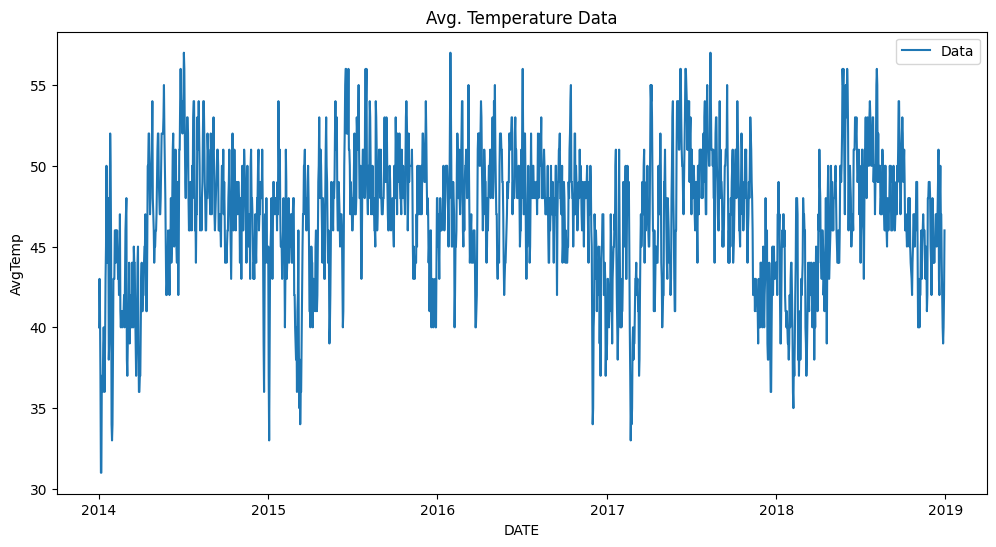

In [49]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot( data['AvgTemp'], label='Data')
plt.xlabel('DATE')
plt.ylabel('AvgTemp')
plt.legend()
plt.title('Avg. Temperature Data')
plt.show()

In [50]:
# Adding lag features to the DataFrame
for i in range(1,6):  # Creating lag features up to 5 days
    data[f'Lag_{i}'] = data['AvgTemp'].shift(i)

# Drop rows with NaN values resulting from creating lag features
data.dropna(inplace=True)

train_size = int(0.8 * len(data))
train_data = data[:train_size]
test_data = data[train_size:]

# Reset index for both train and test data
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

# Define the input features (lag features) and target variable
y_train = train_data['AvgTemp']
y_test = test_data['AvgTemp']
y_test

0      44.0
1      44.0
2      44.0
3      42.0
4      47.0
       ... 
359    40.0
360    39.0
361    40.0
362    42.0
363    46.0
Name: AvgTemp, Length: 364, dtype: float64

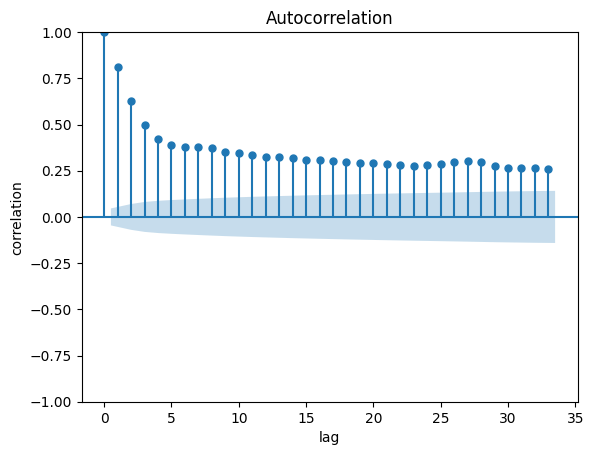

In [51]:
from statsmodels.graphics.tsaplots import plot_acf
series = data['AvgTemp']
plot_acf(series)
plt.xlabel('lag')
plt.ylabel('correlation')
plt.show()

In [52]:
data['AvgTemp'].corr(data['AvgTemp'].shift(1))


0.8125356950898474

In [76]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.api import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Create and train the autoregressive model
lag_order = 365 # Adjust this based on the ACF plot
ar_model = AutoReg(y_train, lags=lag_order)
ar_results = ar_model.fit()


In [77]:
# Make predictions on the test set
y_pred = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=True)
print(y_pred)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')


1452    46.789764
1453    49.058644
1454    48.000526
1455    43.676838
1456    44.993557
          ...    
1811    44.240127
1812    44.398505
1813    43.176803
1814    43.764945
1815    44.363133
Length: 364, dtype: float64
Mean Absolute Error: 3.00
Root Mean Squared Error: 3.72


In [78]:
# y_test = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1, dynamic=False)

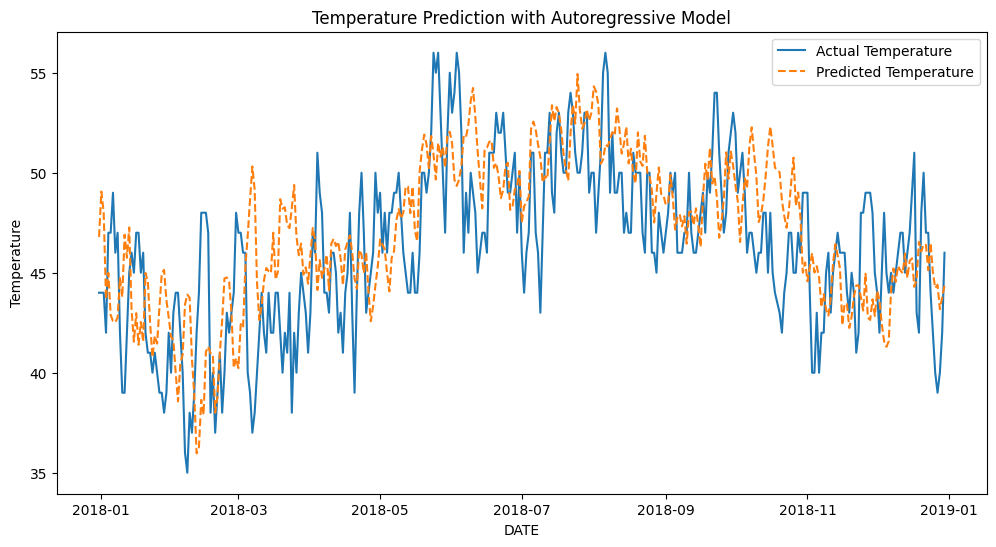

In [79]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(test_data["DATE"] ,y_test, label='Actual Temperature')
plt.plot( test_data["DATE"],y_pred, label='Predicted Temperature', linestyle='--')
plt.xlabel('DATE')
plt.ylabel('Temperature')
plt.legend()
plt.title('Temperature Prediction with Autoregressive Model')
plt.show()


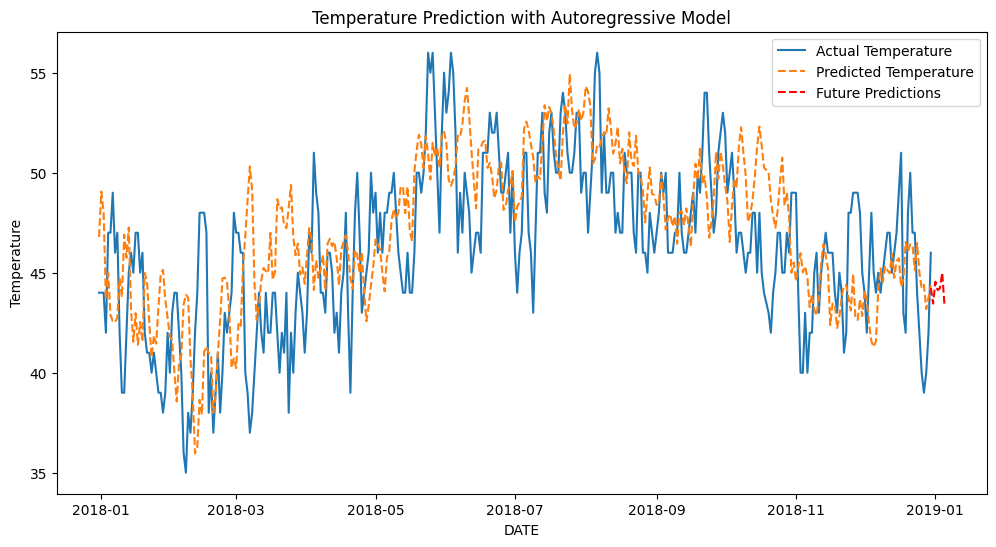

In [80]:
# Define the number of future time steps you want to predict (1 week)
forecast_steps = 7

# Extend the predictions into the future for one year
future_indices = range(len(test_data), len(test_data) + forecast_steps)
future_predictions = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) + forecast_steps - 1, dynamic=True)

# Create DATE indices for the future predictions
future_DATEs = pd.date_range(start=test_data['DATE'].iloc[-1], periods=forecast_steps, freq='D')

# Plot the actual data, existing predictions, and one year of future predictions
plt.figure(figsize=(12, 6))
plt.plot(test_data['DATE'], y_test, label='Actual Temperature')
plt.plot(test_data['DATE'], y_pred, label='Predicted Temperature', linestyle='--')
plt.plot(future_DATEs, future_predictions[-forecast_steps:], label='Future Predictions', linestyle='--', color='red')
plt.xlabel('DATE')
plt.ylabel('Temperature')
plt.legend()
plt.title('Temperature Prediction with Autoregressive Model')
plt.show()
